In [1]:
import numpy as np
import pandas as pd
import os
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow import keras


## Import Model

In [2]:
class UtkMultiOutputModel():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        return x  
    
    def build_race_branch(self, inputs, num_races):
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)        
        return x  
    
    
    def build_age_branch(self, inputs):            
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)        
        return x 
    
    def assemble_full_model(self, width, height, num_races):       
        input_shape = (height, width, 3)        
        inputs = Input(shape=input_shape)        
        #age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        #gender_branch = self.build_gender_branch(inputs)        
        model = Model(inputs=inputs,
                     outputs = [race_branch],
                     name="face_net")        
        return model

In [3]:
IM_WIDTH = IM_HEIGHT = 198
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=3)

In [4]:
#model = keras.models.load_model("./checkpoint_dir/tensorflow_ckpt/Best_model_params.h5")
init_lr = 1e-4
epochs = 200

from tensorflow.keras.optimizers import Adam



In [5]:
import zipfile
with zipfile.ZipFile("profile_pics.zip","r") as zip_ref:
    zip_ref.extractall("profile_pics")

## Read CSV and Load Images

In [6]:
# extract img_path from json and join with csv file on user id
img_dir = './profile_pics/profile pics/'
json_with_image_path = pd.read_json('./User demo profiles.json')
csv = pd.read_csv('./labeled_users.csv')
csv['user_id'] = csv['user_id'].astype(int)
joined_df = csv.join(json_with_image_path.set_index('id'), on = 'user_id',how='inner').drop(['name','screen_name','description','lang'],axis = 1).dropna(axis= 0)
joined_df['user_id'] = joined_df['user_id'].astype(int)
# drop the rows where race category is 'multiracial' or 'Asian'
joined_df = joined_df[joined_df['race'] != 5.0]
joined_df = joined_df[joined_df['race'] != 3.0]
joined_df['race'] = joined_df['race']* 100
img_id = []
img_filenames = joined_df['img_path'].to_list()
for idx, path in enumerate(img_filenames):
    #print(img_dir+'/'+str(path.split('/')[-1]))
    img_filenames[idx]= img_dir+path.split('/')[-1]
    img_id.append(path.split('/')[-1])
joined_df['img_id'] = img_id
joined_df['img_filenames'] = img_filenames


race_lst = []
races = joined_df['race'].to_list()
print(len(races))
for idx, race in enumerate(races):
    if race == 100: # Black
        race_lst.append(0)
    elif race == 200: # Hispanic/Latino
        race_lst.append(1)
    elif race == 400: # White
        race_lst.append(2)
        

joined_df['race'] = race_lst



3244


In [7]:
joined_df.head()

,user_id,is_female,year_born,race,img_path,img_id,img_filenames
0,12488,0.0,1980.0,2,profile pics/60147.jpeg,60147.jpeg,./profile_pics/profile pics/60147.jpeg
1,719703,0.0,1985.0,2,profile pics/60148.jpeg,60148.jpeg,./profile_pics/profile pics/60148.jpeg
6,822540,0.0,1979.0,2,profile pics/60153.jpeg,60153.jpeg,./profile_pics/profile pics/60153.jpeg
7,865071,0.0,1995.0,2,profile pics/60154.jpeg,60154.jpeg,./profile_pics/profile pics/60154.jpeg
8,988211,0.0,1965.0,2,profile pics/60155.jpeg,60155.jpeg,./profile_pics/profile pics/60155.jpeg


In [8]:
face_detect_res = pd.read_csv('./result_all.csv')

In [9]:
filtered_faces_df = joined_df.join(face_detect_res.set_index('img'), on = 'img_id',how='inner').drop(['img_path','is_female'],axis=1)

In [10]:
# choose the rows where coefficient is > 0.9 and is_face is 1
rslt_df = filtered_faces_df[(filtered_faces_df['is_face'] == 1) &
          filtered_faces_df['coefficient'] > 0.9]

In [11]:
rslt_df = rslt_df.reset_index(drop=True)
rslt_df.head()

,user_id,year_born,race,img_id,img_filenames,is_face,coefficient
0,12488,1980.0,2,60147.jpeg,./profile_pics/profile pics/60147.jpeg,1,0.9969
1,865071,1995.0,2,60154.jpeg,./profile_pics/profile pics/60154.jpeg,1,0.9983
2,988211,1965.0,2,60155.jpeg,./profile_pics/profile pics/60155.jpeg,1,0.9998
3,1025311,1955.0,2,60156.jpeg,./profile_pics/profile pics/60156.jpeg,1,0.9995
4,1191741,1973.0,2,60158.jpeg,./profile_pics/profile pics/60158.jpeg,1,0.9814


In [12]:
rslt_df.count()

user_id          2452
year_born        2452
race             2452
img_id           2452
img_filenames    2452
is_face          2452
coefficient      2452
dtype: int64

<AxesSubplot:>

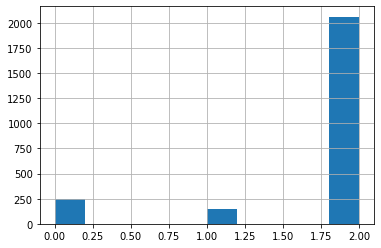

In [13]:
rslt_df['race'].hist()

In [14]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 shuffle=True):
        
        self.df = df.copy()
        self.n = len(df)
        self.X_col = X_col
        self.y_col = y_col
        self.n_race = df[y_col].nunique()
        print(self.n_race)
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        
    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0       
        return im
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def load_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col]
        race_batch = batches[self.y_col]

        X_batch = np.asarray([self.preprocess_image(x) for x in path_batch])
        y0_batch = np.asarray([self.__get_output(y, self.n_race) for y in race_batch])
        return X_batch, y0_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.load_data(batches)
        return X, y
    
    def __len__(self):
        return math.ceil(self.n/self.batch_size)

## Model Training and Accuracy Analysis

### Perform 5-fold cross validation

In [15]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [16]:
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
import math

save_dir = './checkpoint_dir/tensorflow_ckpt/'

# kfold parameters
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)

# define variables
train_bsize = 32
test_bsize = 1
fold_var = 1
cm_holder = [] # confusion matrices holder
prf_holder = [] # precision_recall_f1 holder


for train_index, test_index in kf.split(rslt_df):
    # generate splitted dataframe
    train_df = rslt_df.iloc[train_index]
    test_df = rslt_df.iloc[test_index]
    # create custom datasets for training/validation and class weights for balancing training dataset
    traingen = CustomDataGen(train_df,
                         X_col='img_filenames',
                         y_col='race',
                         batch_size=train_bsize)
    weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_df['race'])
                                               ,train_df['race'])
    weight = {i : weight[i] for i in range(3)}
    valgen = CustomDataGen(test_df,
                         X_col='img_filenames',
                         y_col='race',
                         batch_size=test_bsize, shuffle = False)
    
    IM_WIDTH = IM_HEIGHT = 198
    # create model
    model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=3)
    opt = Adam(lr=init_lr, decay=init_lr / epochs)
    model.compile(optimizer=opt, 
                  loss={

                      'race_output': 'categorical_crossentropy'
                      },
                  metrics={
                      'race_output': 'accuracy'
                      })
    # create CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(traingen, epochs=epochs, callbacks=callbacks_list,validation_data=valgen, class_weight = weight)
    
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("./checkpoint_dir/tensorflow_ckpt/model_"+str(fold_var)+".h5")
    
    results = model.predict(valgen)
    res = np.argmax(results, axis = 1)
    print(results.shape)
    print(res)
    print(res.shape)
    print(np.asarray(test_df['race'].to_list()))
    #results = dict(zip(model.metrics_names,results))
    #VALIDATION_ACCURACY.append(results['accuracy'])
    #VALIDATION_LOSS.append(results['loss'])
    cm_holder.append(confusion_matrix(np.asarray(test_df['race'].to_list()), res))
    report = classification_report(np.asarray(test_df['race'].to_list()), res, target_names=['Black', 'Hispanic/Latino','White'])
    print(report)
    prf_holder.append(report)
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    


3
3


/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=0       2
1       2
2       2
3       2
5       2
       ..
2446    2
2447    2
2449    2
2450    2
2451    2
Name: race, Length: 1961, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
62/62 [==============================] - ETA: 0s - loss: 1.9057 - accuracy: 0.3519
Epoch 00001: val_accuracy improved from -inf to 0.05499, saving model to ./checkpoint_dir/tensorflow_ckpt/model_1.h5
62/62 [==============================] - 8s 129ms/step - loss: 1.9057 - accuracy: 0.3519 - val_loss: 3.6388 - val_accuracy: 0.0550
Epoch 2/200
62/62 [==============================] - ETA: 0s - loss: 1.6384 - accuracy: 0.3519
Epoch 00002: val_accuracy improved from 0.05499 to 0.07536, saving model to ./checkpoint_dir/tensorflow_ckpt/model_1.h5
62/62 [==============================] - 8s 123ms/step - loss: 1.6384 - accuracy: 0.3519 - val_loss: 5.4622 - val_accuracy: 0.0754
Epoch 3/200
62/62 [==============================] - ETA: 0s - loss: 1.5081 - accuracy: 0.3641
Epoch 00003: val_accuracy improved from 0.07536 to 0.08961, saving model to ./checkpoint_dir/tensorflow_ckpt/model_1.h5
62/62 [==============================] - 8s 123ms/step - loss: 1.5081 - accuracy: 0.3641 - val_l

/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=0       2
1       2
4       2
5       2
9       0
       ..
2444    2
2446    2
2447    2
2448    2
2450    2
Name: race, Length: 1961, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
62/62 [==============================] - ETA: 0s - loss: 1.9029 - accuracy: 0.3488
Epoch 00001: val_accuracy improved from -inf to 0.09776, saving model to ./checkpoint_dir/tensorflow_ckpt/model_2.h5
62/62 [==============================] - 8s 126ms/step - loss: 1.9029 - accuracy: 0.3488 - val_loss: 3.0672 - val_accuracy: 0.0978
Epoch 2/200
62/62 [==============================] - ETA: 0s - loss: 1.7010 - accuracy: 0.3432
Epoch 00002: val_accuracy did not improve from 0.09776
62/62 [==============================] - 7s 121ms/step - loss: 1.7010 - accuracy: 0.3432 - val_loss: 6.6473 - val_accuracy: 0.0978
Epoch 3/200
62/62 [==============================] - ETA: 0s - loss: 1.4337 - accuracy: 0.3544
Epoch 00003: val_accuracy did not improve from 0.09776
62/62 [==============================] - 8s 124ms/step - loss: 1.4337 - accuracy: 0.3544 - val_loss: 11.0292 - val_accuracy: 0.0978
Epoch 4/200
62/62 [==============================] - ETA: 0s - loss: 1.4327 - accuracy: 0.3585

/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=0       2
1       2
2       2
3       2
4       2
       ..
2447    2
2448    2
2449    2
2450    2
2451    2
Name: race, Length: 1962, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
62/62 [==============================] - ETA: 0s - loss: 1.9834 - accuracy: 0.3226
Epoch 00001: val_accuracy improved from -inf to 0.04286, saving model to ./checkpoint_dir/tensorflow_ckpt/model_3.h5
62/62 [==============================] - 8s 127ms/step - loss: 1.9834 - accuracy: 0.3226 - val_loss: 2.9132 - val_accuracy: 0.0429
Epoch 2/200
62/62 [==============================] - ETA: 0s - loss: 1.6659 - accuracy: 0.3532
Epoch 00002: val_accuracy did not improve from 0.04286
62/62 [==============================] - 8s 123ms/step - loss: 1.6659 - accuracy: 0.3532 - val_loss: 4.9573 - val_accuracy: 0.0429
Epoch 3/200
62/62 [==============================] - ETA: 0s - loss: 1.5891 - accuracy: 0.3568
Epoch 00003: val_accuracy did not improve from 0.04286
62/62 [==============================] - 7s 117ms/step - loss: 1.5891 - accuracy: 0.3568 - val_loss: 7.0386 - val_accuracy: 0.0429
Epoch 4/200
62/62 [==============================] - ETA: 0s - loss: 1.4368 - accuracy: 0.3741


/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=2       2
3       2
4       2
5       2
6       2
       ..
2445    2
2448    2
2449    2
2450    2
2451    2
Name: race, Length: 1962, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
62/62 [==============================] - ETA: 0s - loss: 1.9258 - accuracy: 0.3502
Epoch 00001: val_accuracy improved from -inf to 0.07959, saving model to ./checkpoint_dir/tensorflow_ckpt/model_4.h5
62/62 [==============================] - 8s 129ms/step - loss: 1.9258 - accuracy: 0.3502 - val_loss: 5.2764 - val_accuracy: 0.0796
Epoch 2/200
62/62 [==============================] - ETA: 0s - loss: 1.5495 - accuracy: 0.3690
Epoch 00002: val_accuracy improved from 0.07959 to 0.08367, saving model to ./checkpoint_dir/tensorflow_ckpt/model_4.h5
62/62 [==============================] - 8s 125ms/step - loss: 1.5495 - accuracy: 0.3690 - val_loss: 10.6427 - val_accuracy: 0.0837
Epoch 3/200
62/62 [==============================] - ETA: 0s - loss: 1.5460 - accuracy: 0.3654
Epoch 00003: val_accuracy improved from 0.08367 to 0.08776, saving model to ./checkpoint_dir/tensorflow_ckpt/model_4.h5
62/62 [==============================] - 8s 126ms/step - loss: 1.5460 - accuracy: 0.3654 - val_

/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=0       2
1       2
2       2
3       2
4       2
       ..
2446    2
2447    2
2448    2
2449    2
2451    2
Name: race, Length: 1962, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
62/62 [==============================] - ETA: 0s - loss: 1.9503 - accuracy: 0.3491
Epoch 00001: val_accuracy improved from -inf to 0.10408, saving model to ./checkpoint_dir/tensorflow_ckpt/model_5.h5
62/62 [==============================] - 8s 126ms/step - loss: 1.9503 - accuracy: 0.3491 - val_loss: 4.2496 - val_accuracy: 0.1041
Epoch 2/200
62/62 [==============================] - ETA: 0s - loss: 1.7009 - accuracy: 0.3486
Epoch 00002: val_accuracy did not improve from 0.10408
62/62 [==============================] - 7s 121ms/step - loss: 1.7009 - accuracy: 0.3486 - val_loss: 9.4446 - val_accuracy: 0.1041
Epoch 3/200
62/62 [==============================] - ETA: 0s - loss: 1.5092 - accuracy: 0.3619
Epoch 00003: val_accuracy improved from 0.10408 to 0.10612, saving model to ./checkpoint_dir/tensorflow_ckpt/model_5.h5
62/62 [==============================] - 8s 125ms/step - loss: 1.5092 - accuracy: 0.3619 - val_loss: 13.0301 - val_accuracy: 0.1061
Epoch 4/200
62/62 [==========

In [17]:
len(cm_holder)

5

In [18]:
cm_sum = np.zeros((3,3))

In [19]:
for each in cm_holder:
    cm_sum += each

In [20]:
cm_sum.astype(int)

array([[  51,   19,  175],
       [  19,   12,  115],
       [ 246,  125, 1690]])